In [1]:
import pandas as pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Bidirectional
from tensorflow.keras import activations
import matplotlib.pyplot as plt

import numpy as np
import time

from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM, Flatten


In [2]:
df = pd.read_csv("data/allSummer_delhi.csv")
df['From Date'] = df['Datetime']

df = df[['From Date','O3','Temperature','SO2','PM10','NO2','CO']] # new features : 6
df = df.replace(to_replace='None', value=np.nan)
df = df.dropna(axis = 0, how = 'all')
df['SO2'].fillna(df['SO2'].median(), inplace=True)

df = df.set_index('From Date')
df = df.iloc[::3, :]
df.to_csv('data1.csv')
print(df.columns)

print(" \nCount total NaN at each column in a DataFrame : \n\n", df.isnull().sum())

Index(['O3', 'Temperature', 'SO2', 'PM10', 'NO2', 'CO'], dtype='object')
 
Count total NaN at each column in a DataFrame : 

 O3             0
Temperature    0
SO2            0
PM10           0
NO2            0
CO             0
dtype: int64


In [14]:
print(df[3000:])

                         O3  Temperature    SO2    PM10     NO2    CO
From Date                                                            
2019-03-08 0:00:00    20.81         64.4  16.37  234.51   66.40  1.76
2019-03-08 3:00:00    18.13         60.8  15.45  228.15   59.23  1.43
2019-03-08 6:00:00    17.03         59.0  13.47  182.06   52.78  1.20
2019-03-08 9:00:00    22.05         68.2  24.23  271.92   66.44  1.46
2019-03-08 12:00:00   66.91         76.8  21.68  173.98   35.96  0.84
...                     ...          ...    ...     ...     ...   ...
2019-05-31 9:00:00    46.97        100.2  19.97  406.19   38.86  0.98
2019-05-31 12:00:00  107.29        107.8  20.84  382.23   36.61  1.06
2019-05-31 15:00:00  122.43        110.0  18.94  279.61   34.50  1.03
2019-05-31 18:00:00  105.73        106.0  17.96  223.24   45.41  1.10
2019-05-31 21:00:00   20.98        100.4  20.05  362.61  117.03  2.98

[680 rows x 6 columns]


In [3]:
# print(df)
dataset = read_csv('data1.csv', index_col=0)
dataset.columns = ['O3','Temperature','SO2','PM10','NO2','CO']
dataset.index.name = 'From Date'
# dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
print("||"*40)
dataset.to_csv('pollution1.csv')

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
                        O3  Temperature   SO2    PM10    NO2     CO
From Date                                                          
2015-03-04 0:00:00   25.34         59.0  6.25  150.57  21.73  10.38
2015-03-04 3:00:00   24.31         55.4  2.75  128.31  27.62  13.01
2015-03-04 6:00:00   19.49         51.8  3.50  159.26  24.17  11.24
2015-03-04 9:00:00   21.90         55.4  2.75  149.90  18.87   6.16
2015-03-04 12:00:00  21.87         69.8  2.00  112.90  19.47  11.43
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


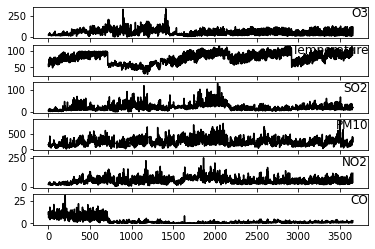

In [4]:
import pandas as pd
from matplotlib import pyplot

dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
groups = [0, 1, 2, 3, 4, 5]

i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group],'k')
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
from sklearn.preprocessing import RobustScaler
# try w different scaler
from IPython.display import display, HTML

# load dataset
dataset = read_csv('pollution1.csv', header=0, index_col=0)
# ensure all data is float
values = dataset.values
values = values.astype('float32')
scaler = RobustScaler()
scaled = scaler.fit_transform(values)
n_hours = 8
n_features = 6 # changed features from 5 to six
reframed = series_to_supervised(scaled, n_hours, 8)
print(reframed.shape)

(3641, 96)


(3641, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (641, 8, 6) (641,)
Epoch 1/25
42/42 - 126s - loss: 0.4851 - val_loss: 0.3604
Epoch 2/25
42/42 - 30s - loss: 0.4702 - val_loss: 0.2790
Epoch 3/25
42/42 - 18s - loss: 0.4065 - val_loss: 0.2007
Epoch 4/25
42/42 - 17s - loss: 0.3431 - val_loss: 0.1581
Epoch 5/25
42/42 - 18s - loss: 0.3238 - val_loss: 0.1430
Epoch 6/25
42/42 - 16s - loss: 0.2942 - val_loss: 0.1210
Epoch 7/25
42/42 - 14s - loss: 0.3137 - val_loss: 0.1176
Epoch 8/25
42/42 - 10s - loss: 0.2912 - val_loss: 0.1101
Epoch 9/25
42/42 - 10s - loss: 0.2994 - val_loss: 0.1081
Epoch 10/25
42/42 - 11s - loss: 0.2914 - val_loss: 0.1043
Epoch 11/25
42/42 - 9s - loss: 0.2949 - val_loss: 0.1024
Epoch 12/25
42/42 - 11s - loss: 0.2786 - val_loss: 0.0980
Epoch 13/25
42/42 - 11s - loss: 0.3083 - val_loss: 0.1042
Epoch 14/25
42/42 - 12s - loss: 0.2822 - val_loss: 0.0955
Epoch 15/25
42/42 - 10s - loss: 0.3033 - val_loss: 0.0950
Epoch 16/25
42/42 - 11s - loss: 0.2765 - val_loss: 0.0991
Epoch 

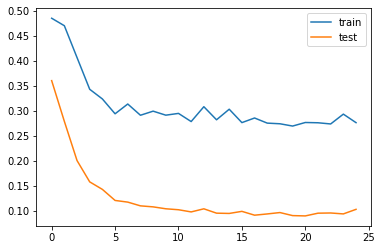

done | time taken: 483.539942 seconds
Test RMSE: 15.651
12.37433
0.7488165250245318
(3641, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (641, 8, 6) (641,)
Epoch 1/25
42/42 - 180s - loss: 0.5192 - val_loss: 0.3688
Epoch 2/25
42/42 - 21s - loss: 0.4506 - val_loss: 0.2797
Epoch 3/25
42/42 - 19s - loss: 0.4410 - val_loss: 0.2333
Epoch 4/25
42/42 - 18s - loss: 0.3326 - val_loss: 0.1600
Epoch 5/25
42/42 - 20s - loss: 0.3538 - val_loss: 0.1495
Epoch 6/25
42/42 - 22s - loss: 0.3101 - val_loss: 0.1292
Epoch 7/25
42/42 - 24s - loss: 0.3339 - val_loss: 0.1221
Epoch 8/25
42/42 - 22s - loss: 0.2977 - val_loss: 0.1185
Epoch 9/25
42/42 - 20s - loss: 0.3210 - val_loss: 0.1165
Epoch 10/25
42/42 - 16s - loss: 0.2932 - val_loss: 0.1083
Epoch 11/25
42/42 - 13s - loss: 0.3146 - val_loss: 0.1119
Epoch 12/25
42/42 - 14s - loss: 0.2873 - val_loss: 0.1016
Epoch 13/25
42/42 - 13s - loss: 0.3023 - val_loss: 0.1002
Epoch 14/25
42/42 - 13s - loss: 0.2805 - val_loss: 0.0991
Epoch 15/25
42/42 - 13s - loss: 0.291

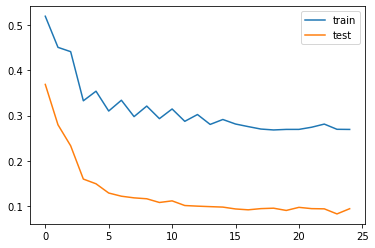

done | time taken: 1028.273947 seconds
Test RMSE: 14.981
11.50305
0.7698448869669199
(3641, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (641, 8, 6) (641,)
Epoch 1/25
42/42 - 110s - loss: 0.5194 - val_loss: 0.3818
Epoch 2/25
42/42 - 18s - loss: 0.4408 - val_loss: 0.2892
Epoch 3/25
42/42 - 14s - loss: 0.4529 - val_loss: 0.2394
Epoch 4/25
42/42 - 13s - loss: 0.3381 - val_loss: 0.1730
Epoch 5/25
42/42 - 18s - loss: 0.3589 - val_loss: 0.1550
Epoch 6/25
42/42 - 19s - loss: 0.3018 - val_loss: 0.1261
Epoch 7/25
42/42 - 18s - loss: 0.3541 - val_loss: 0.1346
Epoch 8/25
42/42 - 18s - loss: 0.3055 - val_loss: 0.1179
Epoch 9/25
42/42 - 20s - loss: 0.3329 - val_loss: 0.1116
Epoch 10/25
42/42 - 18s - loss: 0.2992 - val_loss: 0.1173
Epoch 11/25
42/42 - 18s - loss: 0.3086 - val_loss: 0.1093
Epoch 12/25
42/42 - 20s - loss: 0.2898 - val_loss: 0.1057
Epoch 13/25
42/42 - 17s - loss: 0.2783 - val_loss: 0.0955
Epoch 14/25
42/42 - 17s - loss: 0.2770 - val_loss: 0.0939
Epoch 15/25
42/42 - 15s - loss: 0.27

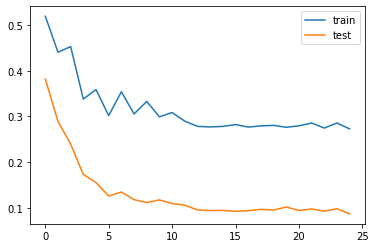

done | time taken: 1574.525475 seconds
Test RMSE: 14.344
11.16696
0.789006072964114
(3641, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (641, 8, 6) (641,)
Epoch 1/25
42/42 - 167s - loss: 0.4958 - val_loss: 0.3734
Epoch 2/25
42/42 - 15s - loss: 0.4646 - val_loss: 0.2765
Epoch 3/25
42/42 - 16s - loss: 0.4247 - val_loss: 0.2105
Epoch 4/25
42/42 - 19s - loss: 0.3291 - val_loss: 0.1465
Epoch 5/25
42/42 - 19s - loss: 0.3490 - val_loss: 0.1423
Epoch 6/25
42/42 - 22s - loss: 0.3105 - val_loss: 0.1274
Epoch 7/25
42/42 - 20s - loss: 0.3369 - val_loss: 0.1208
Epoch 8/25
42/42 - 19s - loss: 0.3012 - val_loss: 0.1174
Epoch 9/25
42/42 - 15s - loss: 0.3160 - val_loss: 0.1077
Epoch 10/25
42/42 - 17s - loss: 0.2904 - val_loss: 0.1044
Epoch 11/25
42/42 - 22s - loss: 0.2914 - val_loss: 0.0965
Epoch 12/25
42/42 - 17s - loss: 0.2803 - val_loss: 0.0954
Epoch 13/25
42/42 - 21s - loss: 0.2837 - val_loss: 0.0942
Epoch 14/25
42/42 - 18s - loss: 0.2784 - val_loss: 0.0950
Epoch 15/25
42/42 - 16s - loss: 0.281

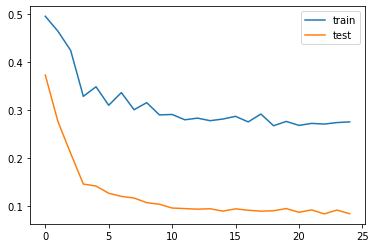

done | time taken: 2205.809478 seconds
Test RMSE: 14.180
10.973863
0.793822215744551
(3641, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (641, 8, 6) (641,)
Epoch 1/25
42/42 - 192s - loss: 0.4921 - val_loss: 0.3567
Epoch 2/25
42/42 - 18s - loss: 0.4561 - val_loss: 0.2766
Epoch 3/25
42/42 - 18s - loss: 0.4365 - val_loss: 0.2220
Epoch 4/25
42/42 - 19s - loss: 0.3414 - val_loss: 0.1632
Epoch 5/25
42/42 - 20s - loss: 0.3413 - val_loss: 0.1439
Epoch 6/25
42/42 - 22s - loss: 0.3096 - val_loss: 0.1285
Epoch 7/25
42/42 - 21s - loss: 0.3355 - val_loss: 0.1234
Epoch 8/25
42/42 - 28s - loss: 0.3039 - val_loss: 0.1204
Epoch 9/25
42/42 - 20s - loss: 0.3164 - val_loss: 0.1190
Epoch 10/25
42/42 - 16s - loss: 0.2919 - val_loss: 0.1020
Epoch 11/25
42/42 - 17s - loss: 0.2921 - val_loss: 0.0982
Epoch 12/25
42/42 - 16s - loss: 0.2866 - val_loss: 0.1059
Epoch 13/25
42/42 - 16s - loss: 0.2918 - val_loss: 0.0973
Epoch 14/25
42/42 - 19s - loss: 0.2770 - val_loss: 0.0961
Epoch 15/25
42/42 - 10s - loss: 0.27

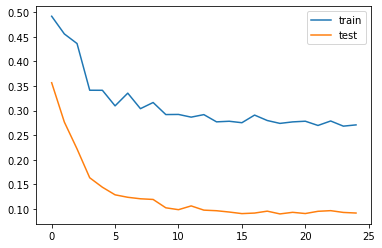

done | time taken: 2754.785978 seconds
Test RMSE: 14.729
11.711677
0.777543811872935
(3641, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (641, 8, 6) (641,)
Epoch 1/25
42/42 - 85s - loss: 0.4968 - val_loss: 0.3538
Epoch 2/25
42/42 - 13s - loss: 0.4792 - val_loss: 0.2601
Epoch 3/25
42/42 - 13s - loss: 0.3912 - val_loss: 0.1957
Epoch 4/25
42/42 - 12s - loss: 0.3471 - val_loss: 0.1541
Epoch 5/25
42/42 - 12s - loss: 0.3294 - val_loss: 0.1373
Epoch 6/25
42/42 - 12s - loss: 0.3042 - val_loss: 0.1237
Epoch 7/25
42/42 - 15s - loss: 0.3211 - val_loss: 0.1212
Epoch 8/25
42/42 - 12s - loss: 0.2953 - val_loss: 0.1124
Epoch 9/25
42/42 - 12s - loss: 0.3129 - val_loss: 0.1150
Epoch 10/25
42/42 - 11s - loss: 0.2923 - val_loss: 0.0991
Epoch 11/25
42/42 - 13s - loss: 0.3129 - val_loss: 0.1046
Epoch 12/25
42/42 - 11s - loss: 0.2939 - val_loss: 0.1026
Epoch 13/25
42/42 - 11s - loss: 0.2980 - val_loss: 0.0948
Epoch 14/25
42/42 - 12s - loss: 0.2791 - val_loss: 0.0925
Epoch 15/25
42/42 - 11s - loss: 0.290

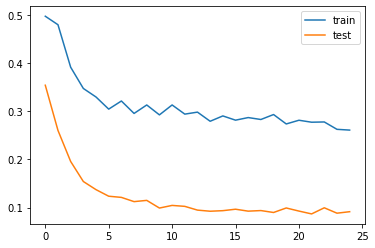

done | time taken: 3116.760092 seconds
Test RMSE: 14.745
11.341766
0.7770550991636516
(3641, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (641, 8, 6) (641,)
Epoch 1/25
42/42 - 96s - loss: 0.4809 - val_loss: 0.3440
Epoch 2/25
42/42 - 13s - loss: 0.4697 - val_loss: 0.2723
Epoch 3/25
42/42 - 13s - loss: 0.4187 - val_loss: 0.2218
Epoch 4/25
42/42 - 15s - loss: 0.3371 - val_loss: 0.1615
Epoch 5/25
42/42 - 13s - loss: 0.3414 - val_loss: 0.1485
Epoch 6/25
42/42 - 13s - loss: 0.2990 - val_loss: 0.1205
Epoch 7/25
42/42 - 13s - loss: 0.3328 - val_loss: 0.1189
Epoch 8/25
42/42 - 13s - loss: 0.3005 - val_loss: 0.1150
Epoch 9/25
42/42 - 13s - loss: 0.3183 - val_loss: 0.1125
Epoch 10/25
42/42 - 13s - loss: 0.2894 - val_loss: 0.1033
Epoch 11/25
42/42 - 12s - loss: 0.2954 - val_loss: 0.1013
Epoch 12/25
42/42 - 12s - loss: 0.2825 - val_loss: 0.1026
Epoch 13/25
42/42 - 13s - loss: 0.2861 - val_loss: 0.0963
Epoch 14/25
42/42 - 15s - loss: 0.2766 - val_loss: 0.0964
Epoch 15/25
42/42 - 14s - loss: 0.28

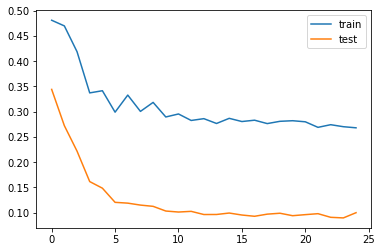

done | time taken: 3523.558599 seconds
Test RMSE: 15.406
12.35679
0.7566166056094847
(3641, 96)
(3000, 48) 3000 (3000,)
(3000, 8, 6) (3000,) (641, 8, 6) (641,)
Epoch 1/25
42/42 - 162s - loss: 0.4934 - val_loss: 0.3638
Epoch 2/25
42/42 - 18s - loss: 0.4503 - val_loss: 0.2661
Epoch 3/25
42/42 - 26s - loss: 0.4217 - val_loss: 0.2107
Epoch 4/25
42/42 - 24s - loss: 0.3403 - val_loss: 0.1580
Epoch 5/25
42/42 - 21s - loss: 0.3457 - val_loss: 0.1455
Epoch 6/25
42/42 - 18s - loss: 0.3140 - val_loss: 0.1241
Epoch 7/25
42/42 - 17s - loss: 0.3378 - val_loss: 0.1190
Epoch 8/25
42/42 - 17s - loss: 0.3004 - val_loss: 0.1174
Epoch 9/25
42/42 - 17s - loss: 0.3220 - val_loss: 0.1112
Epoch 10/25
42/42 - 17s - loss: 0.2990 - val_loss: 0.1055
Epoch 11/25
42/42 - 16s - loss: 0.2946 - val_loss: 0.0983
Epoch 12/25
42/42 - 27s - loss: 0.2810 - val_loss: 0.0980
Epoch 13/25
42/42 - 21s - loss: 0.2847 - val_loss: 0.0973
Epoch 14/25
42/42 - 14s - loss: 0.2772 - val_loss: 0.0962
Epoch 15/25
42/42 - 16s - loss: 0.28

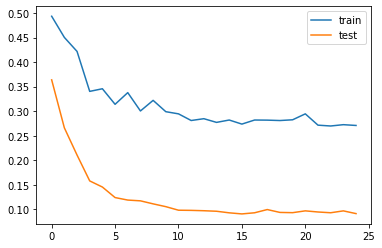

done | time taken: 4187.030474 seconds
Test RMSE: 14.730
11.672044
0.7775137658668992


In [15]:
rmses = []
maes = []
rsquared = []
times = []

from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(
#     min_delta=0.001, # minimium amount of change to count as an improvement
#     patience=20, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

from sklearn.preprocessing import RobustScaler
# try w different scaler
from IPython.display import display, HTML

t0 = time.time()

for x in range(8):
    # load dataset
    dataset = read_csv('pollution1.csv', header=0, index_col=0)
    # dataset = dataset[2000:6000]
    # ensure all data is float
    values = dataset.values
    values = values.astype('float32')
    scaler = RobustScaler()
    scaled = scaler.fit_transform(values)
    n_hours = 8
    n_features = 6 # changed features from 5 to six
    reframed = series_to_supervised(scaled, n_hours, 8)
    print(reframed.shape)


    # split into train and test sets
    values = reframed.values
    n_train_hours = 3000
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]

    # split into input and outputs
    n_obs = n_hours * n_features
    train_X = train[:, :n_obs]
    train_y = train[:, -n_features]
    test_X = test[:, :n_obs]
    test_y = test[:, -n_features]

    print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    n_out = 1
    #######


    # Building the model
    model = Sequential()
    # Adding a Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(256,return_sequences=True, dropout=0.2, input_shape=(n_hours,n_features)))) # change number of neurons to 256, 128
    model.add(Bidirectional(LSTM(128, dropout=0.2)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')


    history = model.fit(train_X, train_y, epochs=25, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False) # try combo


    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat) #################
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    from sklearn.metrics import mean_absolute_error, r2_score

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -5:]), axis=1) # changed from -7 to -11 to -5 # because it is n_features-1. also had really good results for -11?
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = (mean_absolute_error(inv_y, inv_yhat))
    r2 = (r2_score(inv_y, inv_yhat))



    t1 = time.time()


    total = t1-t0

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    print("done | time taken: %f seconds" %total)
    print('Test RMSE: %.3f' % rmse)
    print(mae)
    print(r2)
    #print(mae)
    
    maes.append(mae)
    rmses.append(rmse)
    rsquared.append(r2)
    times.append(total)

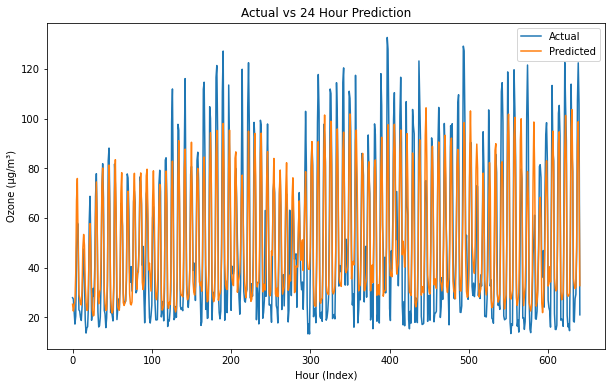

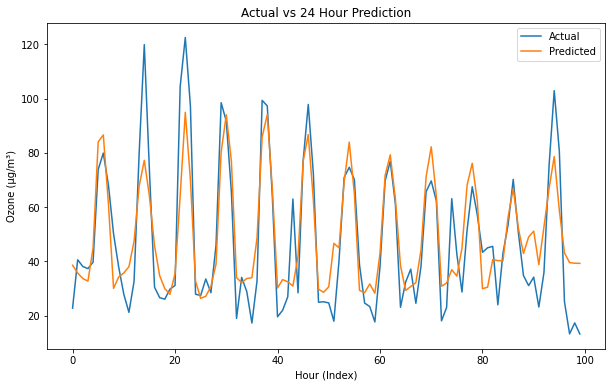

In [9]:
### plots

# entire thing

actual = inv_y
pred2 = inv_yhat
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

# sample

actual = inv_y[200:300]
pred2 = inv_yhat[200:300]
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

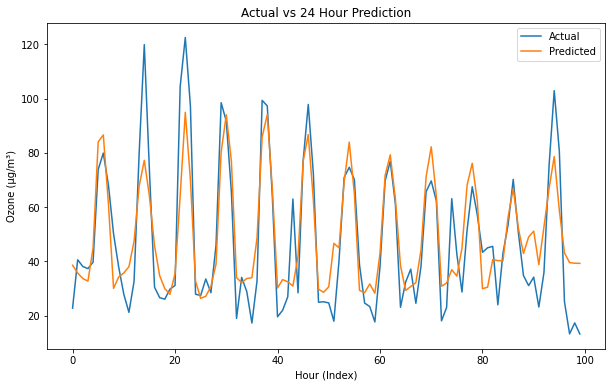

In [10]:
sample = (dataset['O3'][2200:2400])

actual = inv_y[200:300]
pred2 = inv_yhat[200:300]
plt.figure(figsize=(10,6))
plt.plot( list(actual))
plt.plot( list(pred2))
plt.title("Actual vs 24 Hour Prediction")
plt.ylabel('Ozone (µg/m³)')
plt.xlabel("Hour (Index)")
plt.legend(('Actual','Predicted'))
plt.show()

In [ ]:
print('run test')